# Particle model: diffusion + first order reaction
This notebook demonstrates how to compute the effectiveness factor of a particle model with diffusion and a first-order reaction.

A non-uniform grid is used, refined near the particle surface, to ensure accurate computation for larger Thiele moduli.

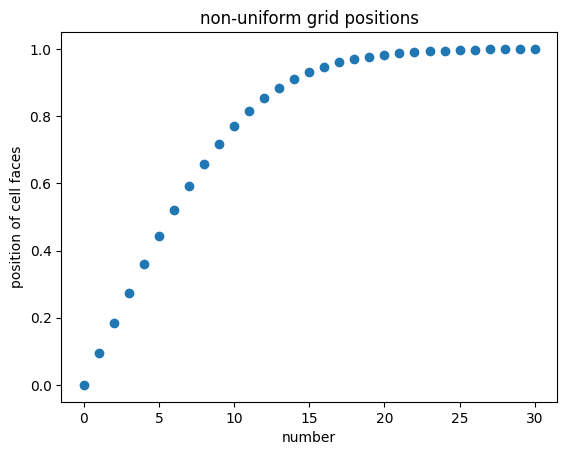

In [ ]:
# Import required libraries
import matplotlib.pyplot as plt
from pymrm import non_uniform_grid

# Define grid parameters
shape_c = (30,)  # Number of cells in the grid
R = 1  # Radius of the particle
dr_large = 0.1*R  # Initial large spacing for the grid

# Generate a non-uniform grid refined near the particle surface
r_f = non_uniform_grid(0, R, shape_c[0]+1, dr_large, 0.75)

# Plot the non-uniform grid positions
plt.plot(r_f, marker = 'o', linestyle = '')
plt.title("non-uniform grid positions")
plt.xlabel("number")
plt.ylabel("position of cell faces")
plt.show()

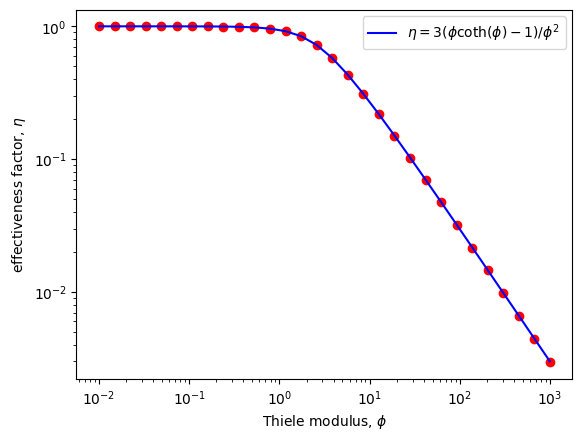

In [ ]:
# Import required libraries
import math
import numpy as np
import scipy as sp
from scipy.sparse import linalg as sla
import matplotlib.pyplot as plt
from pymrm import construct_grad, construct_div

# Define constants and parameters
D = 1  # Diffusion coefficient
phis = np.logspace(-2,3,30)  # Range of Thiele moduli
bc = ({'a':1 , 'b':0, 'd':0},{'a':0, 'b':1, 'd':1})  # Boundary conditions

# Construct gradient and divergence matrices
grad_mat, grad_bc = construct_grad(shape_c, r_f, bc=bc)
div_mat = construct_div(shape_c, r_f, nu=2, axis=0)

# Compute Laplacian matrix and boundary conditions
lapl_mat = div_mat @ grad_mat
lapl_bc = div_mat @ grad_bc

# Loop over Thiele moduli to compute effectiveness factor
for phi in phis:
    k = phi**2*D/R  # Reaction rate constant
    jac = k*sp.sparse.eye(math.prod(shape_c), format='csc') - lapl_mat  # Jacobian matrix
    jac_lu = sla.splu(jac)  # LU decomposition of the Jacobian

    # Solve for concentration profile
    c = jac_lu.solve(lapl_bc.toarray())
    k_app = (grad_mat[[-1],:] @ c + grad_bc[[-1]].toarray())[[0]]*(3*D/R)  # Apparent reaction rate
    eta = k_app/k  # Effectiveness factor
    c = c.reshape(shape_c)  # Reshape concentration profile

    # Plot effectiveness factor for the current Thiele modulus
    plt.loglog(phi, eta, marker = 'o', linestyle = '', color = 'red')

# Plot analytical solution for comparison
plt.loglog(phis, 3*(phis/np.tanh(phis)-1)/(phis*phis), color = 'blue', label = r'$\eta = 3(\phi \coth(\phi)-1)/\phi^2$')
plt.xlabel(r'Thiele modulus, $\phi$')
plt.ylabel(r'effectiveness factor, $\eta$')
plt.legend()
plt.show()